In [154]:
import numpy as np
import wave
import librosa
import pyaudio
import wave
from array import array
from collections import deque
from concurrent.futures import ThreadPoolExecutor
from glob import glob
from multiprocessing import cpu_count
from queue import Queue
from typing import List
import librosa
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import logmmse
import pyaudio

from voice_presentation_control.action_matcher import ActionMatcher
from voice_presentation_control.mic import Mic
from voice_presentation_control.recognizer import Recognizer

audio = pyaudio.PyAudio()

In [155]:
wavefile = wave.open(f"C:/UserD/Program/Project_Python/voice-presentation-control/voice_presentation_control/wav_files/test_save_{476}.wav", "rb")

In [156]:
wave_raw=wavefile.readframes(wavefile.getnframes())
wave_raw=array("h", wave_raw)
new_wave_raw=array("h", wave_raw)

In [157]:

min_threshold=40
max_volume_value=15000

def volume_process(wave_values):
  # def volume_process_func(wave_values):
  #   if wave_values<= min_threshold and wave_values>= -min_threshold :
  #     wave_values=0
  #   elif wave_values>min_threshold:
  #     wave_values = int((wave_values-min_threshold)/max_g*max_volume_value)
  #   elif wave_values < 0:
  #     wave_values = int((wave_values+min_threshold)/min_g*max_volume_value)
  #   return wave_values

  max_values  = max(abs(np.array(wave_values)))
  wave_values = (wave_values/max_values)*max_volume_value
  #wave_values = map(volume_process_func,wave_values)
  wave_values=array('h',list(wave_values.astype(int)))
  return wave_values
new_wave_raw = logmmse.logmmse(data=np.array(new_wave_raw), sampling_rate=44100,noise_threshold=0.1,window_size=0)
new_wave_raw = volume_process(array('h',list(new_wave_raw)))


In [158]:
window_size=5
def moving_average(avg_wave, n=7) :
    ret = np.cumsum(avg_wave, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return np.pad(ret[n - 1:] / n,n//2,mode='constant',constant_values=(0,))
#avg_wave=np.array(array('h',new_wave_raw))
#avg_wave=moving_average(avg_wave,window_size)
#new_wave_raw=array('h',avg_wave.astype(int))

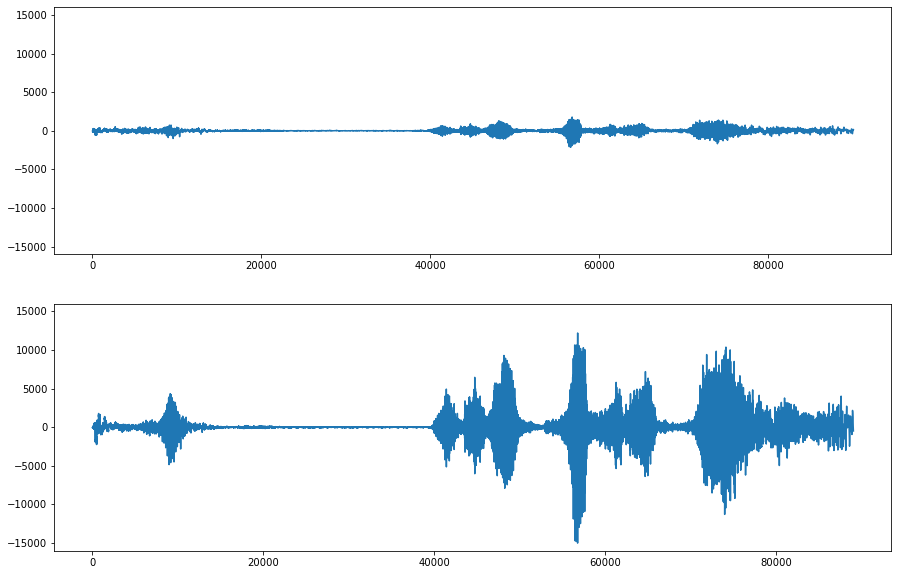

In [159]:
fig,ax = plt.subplots(2,1,figsize=(15,10))

for a in ax:
  a.set_ylim([-16000,16000])
  
ax[0].plot(wave_raw)

ax[1].plot(new_wave_raw)
plt.show()

c:\UserC\Anaconda\envs\torch\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'POW')

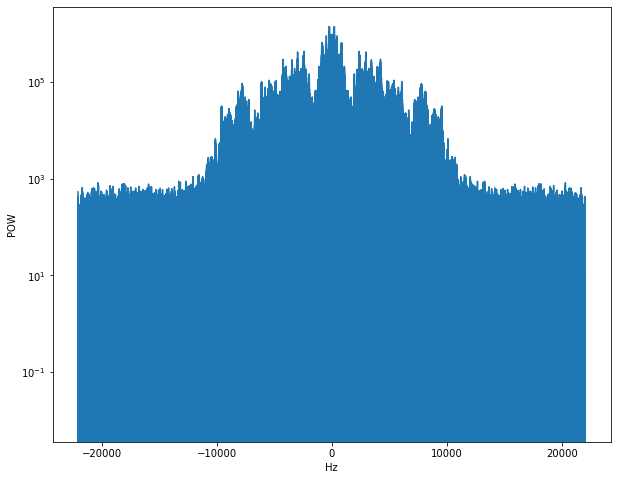

In [160]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
fft_wave=np.array(array('h',wave_raw))
#fft_wave = logmmse.logmmse(data=fft_wave, sampling_rate=44100,noise_threshold=0.15,window_size=0)
sample_num = len(fft_wave)
sample_rate = 44100
audio_max = np.max(abs(fft_wave))
times = np.arange(sample_num)/sample_rate
vib_fft = np.fft.fft(fft_wave)
fft_freqs =np.fft.fftfreq(sample_num,times[1]-times[0])

vib_fft_pow = np.abs(vib_fft)

#plt.plot(fft_freqs[fft_freqs>0],vib_fft_pow[fft_freqs>0])
#plt.xlabel('Hz')
#plt.ylabel('POW')

plt.semilogy(fft_freqs,vib_fft)
plt.xlabel('Hz')
plt.ylabel('POW')

c:\UserC\Anaconda\envs\torch\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'POW')

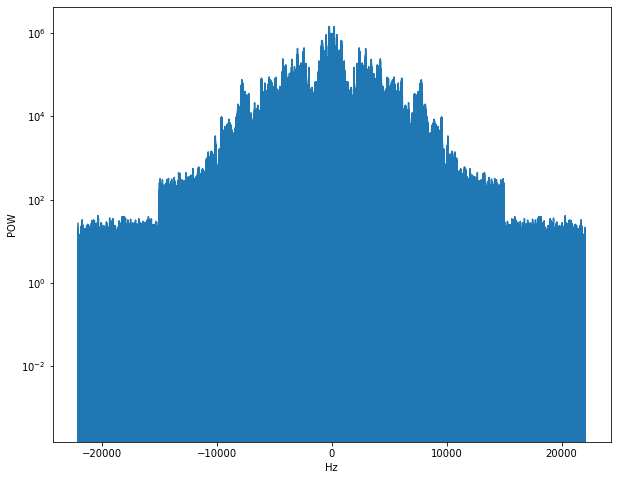

In [161]:
#fund_freq = fft_freqs[vib_fft_pow.argmax()]
fig,ax = plt.subplots(1,1,figsize=(10,8))
fft_filter = vib_fft.copy()
noise_indices = np.where((abs(fft_freqs)>8000) & (abs(fft_freqs)<10000))
fft_filter[noise_indices] = fft_filter[noise_indices]*0.3#.1

noise_indices = np.where(abs(fft_freqs)>=10000)
fft_filter[noise_indices] = fft_filter[noise_indices]*0.5#.05

noise_indices = np.where(abs(fft_freqs)>=15000)
fft_filter[noise_indices] = fft_filter[noise_indices]*0.1

noise_indices = np.where((abs(fft_freqs)<=8000) & (abs(fft_freqs)>3000))
fft_filter[noise_indices] = fft_filter[noise_indices]*0.8

noise_indices = np.where((abs(fft_freqs)<=3000)&(abs(fft_freqs)>600))
fft_filter[noise_indices] = fft_filter[noise_indices]*1#0.85

noise_indices = np.where((abs(fft_freqs)<=600))
fft_filter[noise_indices] = fft_filter[noise_indices]

#noise_indices = np.where((abs(fft_freqs)<=100))
#fft_filter[noise_indices] = fft_filter[noise_indices]*0.05

#noise_indices = np.where(fft_freqs<30)
#fft_filter[noise_indices] = 0
#target_indices = np.where(fft_freqs<=2000)
#fft_filter[target_indices] = fft_filter[target_indices]*10

#filter_pow = np.abs(fft_filter)

plt.semilogy(fft_freqs,fft_filter)
plt.xlabel('Hz')
plt.ylabel('POW')

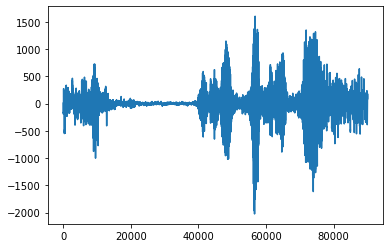

In [162]:
filter_wave_ifft = np.fft.ifft(fft_filter).real.astype(int)
filter_wave = array('h',filter_wave_ifft.astype(int))

plt.plot(filter_wave_ifft)

In [163]:

min_threshold=0
#volume_filter_wave = logmmse.logmmse(data=filter_wave_ifft, sampling_rate=44100,noise_threshold=0.15,window_size=0)

volume_filter_wave = volume_process(array('h',filter_wave_ifft))



In [164]:
wave_raw=bytes(wave_raw)
filter_wave_raw=bytes(filter_wave)
volume_wave_raw=bytes(new_wave_raw)
volume_filter_wave_raw=bytes(volume_filter_wave)

In [165]:
num_files = len(glob("C:/UserD/Program/Project_Python/voice-presentation-control/voice_presentation_control/wav_files/*.wav"))
print(num_files)
wavefile = wave.open(f"C:/UserD/Program/Project_Python/voice-presentation-control/voice_presentation_control/wav_files/test_save_{num_files}_modify_volume_.wav", "w")
wavefile.setnchannels(1)
wavefile.setsampwidth(audio.get_sample_size(pyaudio.paInt16))
wavefile.setframerate(44100)
wavefile.writeframes(array('h',np.array(array('h',volume_wave_raw))))

num_files = len(glob("C:/UserD/Program/Project_Python/voice-presentation-control/voice_presentation_control/wav_files/*.wav"))
print(num_files)
wavefile = wave.open(f"C:/UserD/Program/Project_Python/voice-presentation-control/voice_presentation_control/wav_files/test_save_{num_files}_modify_filter.wav", "w")
wavefile.setnchannels(1)
wavefile.setsampwidth(audio.get_sample_size(pyaudio.paInt16))
wavefile.setframerate(44100)
wavefile.writeframes(array('h',np.array(array('h',filter_wave))))

num_files = len(glob("C:/UserD/Program/Project_Python/voice-presentation-control/voice_presentation_control/wav_files/*.wav"))
print(num_files)
wavefile = wave.open(f"C:/UserD/Program/Project_Python/voice-presentation-control/voice_presentation_control/wav_files/test_save_{num_files}_modify_filter_volume.wav", "w")
wavefile.setnchannels(1)
wavefile.setsampwidth(audio.get_sample_size(pyaudio.paInt16))
wavefile.setframerate(44100)
wavefile.writeframes(array('h',np.array(array('h',volume_filter_wave_raw))))

504
505
506


In [166]:
import os,typer,json
with open( "C:/UserD/Program/Project_Python/voice-presentation-control/voice_presentation_control/configs/actions.json", encoding="utf-8") as f:
    data: dict = json.load(f)

    if data.get('en'):
        actions = data['en']
    else:
        typer.echo(f"Language '{'en'}' is not set in actions.json")
        raise typer.Exit()
grammar = '["{}", "[unk]"]'.format('", "'.join(actions.keys()))
recognizer=Recognizer(lang='en',grammar=grammar)

In [167]:
result = recognizer.recognize(wave_raw, 44100)
#new_record_frames = [ f*2 for f in record_frames]
#self.save_frames_to_wav(new_record_frames)
if result is not None:
    print(result, end="1\n", flush=True)
    
result = recognizer.recognize(volume_wave_raw, 44100)
#new_record_frames = [ f*2 for f in record_frames]
#self.save_frames_to_wav(new_record_frames)
if result is not None:
    print(result, end="2\n", flush=True)
    
result = recognizer.recognize(filter_wave_raw, 44100)
#new_record_frames = [ f*2 for f in record_frames]
#self.save_frames_to_wav(new_record_frames)
if result is not None:
    print(result, end="3\n", flush=True)
    
    
result = recognizer.recognize(volume_filter_wave_raw, 44100)
#new_record_frames = [ f*2 for f in record_frames]
#self.save_frames_to_wav(new_record_frames)
if result is not None:
    print(result, end="4\n", flush=True)

presentation mode1
[unk]2
3
presentation mode4


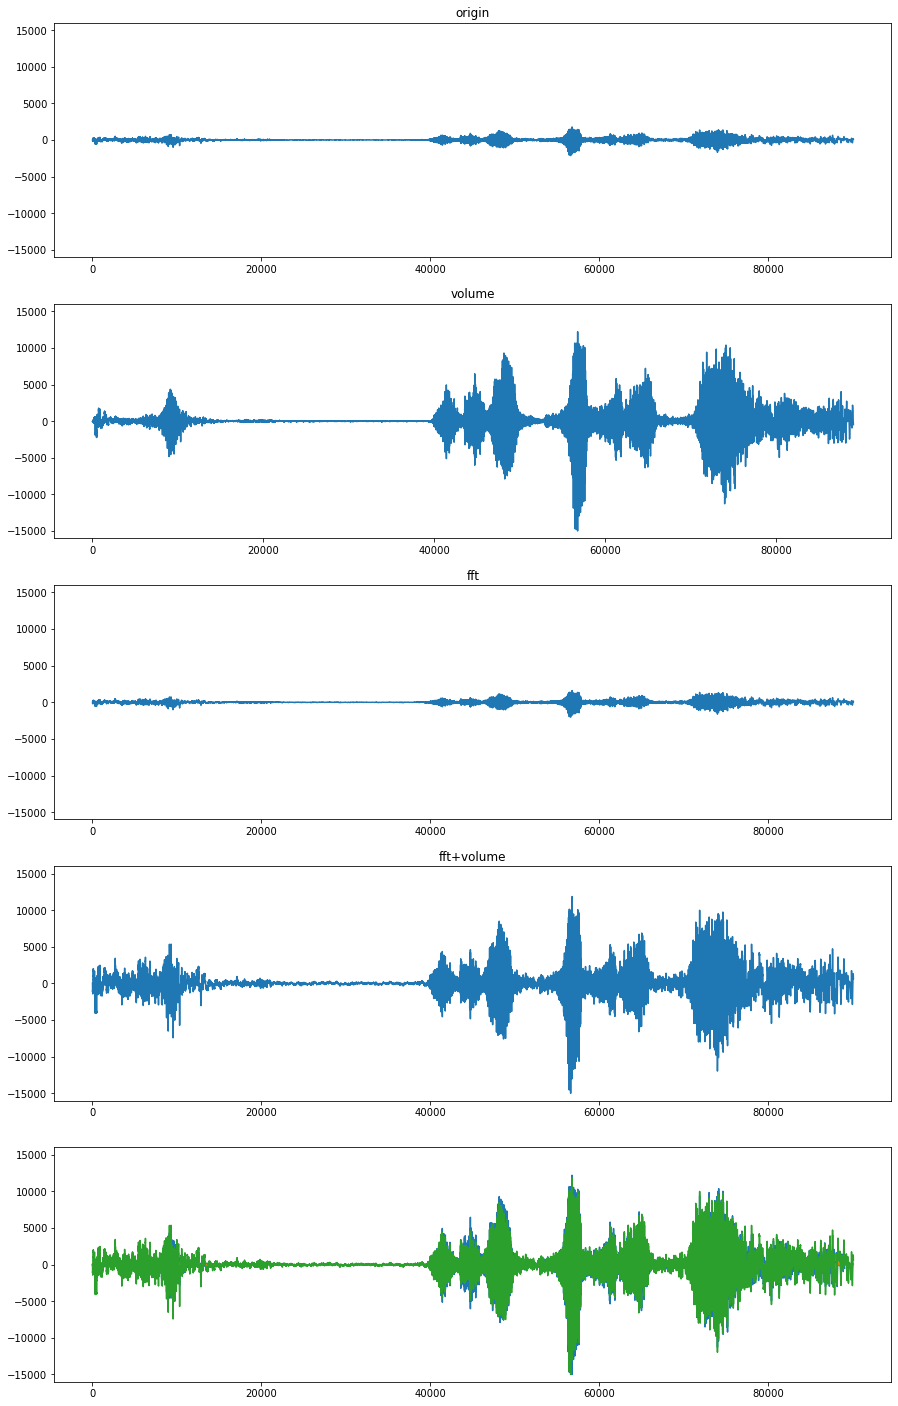

In [168]:
fig,ax = plt.subplots(5,1,figsize=(15,25))

for a in ax:
  a.set_ylim([-16000,16000])

ax[0].plot(np.array(array('h',wave_raw)))
ax[0].set_title('origin')
ax[1].plot(np.array(array('h',volume_wave_raw)))
ax[1].set_title('volume')
ax[2].plot(np.array(array('h',filter_wave_raw)))
ax[2].set_title('fft')
ax[3].plot(np.array(array('h',volume_filter_wave_raw)))
ax[3].set_title('fft+volume')

ax[4].plot(np.array(array('h',volume_wave_raw)))
ax[4].plot(np.array(array('h',filter_wave_raw)))
ax[4].plot(np.array(array('h',volume_filter_wave_raw)))
plt.show()

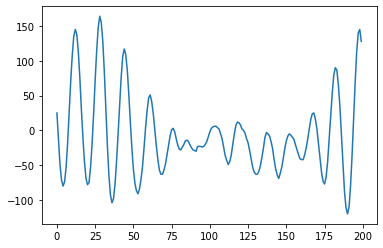

In [169]:
plt.plot(np.array(array('h',wave_raw))[40000:40200])